In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tiktoken

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import math
import tiktoken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [4]:
class CFG:
    eng2de = {
        'train': '/content/drive/MyDrive/wmt-2014-en2de/wmt14_translate_de-en_train.csv',
        'test': '/content/drive/MyDrive/wmt-2014-en2de/wmt14_translate_de-en_test.csv',
        'val': '/content/drive/MyDrive/wmt-2014-en2de/wmt14_translate_de-en_validation.csv'
    }
    max_seq_len = 50
    batch_size = 64
    encoding_scheme = 'cl100k_base'

In [5]:
def load_data(dataset='eng2de', cfg=CFG):
    nrows = 18000
    train = pd.read_csv(cfg.eng2de['train'], lineterminator='\n', nrows=nrows)
    test = pd.read_csv(cfg.eng2de['test'], lineterminator='\n', nrows=nrows)
    val = pd.read_csv(cfg.eng2de['val'], lineterminator='\n', nrows=nrows)
    return train, val, test

train, test, val = load_data()

In [6]:
class Tokenizer:
    def __init__(self, encoding_scheme='cl100k_base', max_len=None):
        self.tokenizer = tiktoken.get_encoding(encoding_scheme)
        self.sos_token = '<sos>'
        self.eos_token = '<eos>'
        self.pad_token = '<pad>'
        n_vocab = self.vocab_size
        self.special_tokens = {
            self.sos_token: n_vocab,
            self.eos_token: n_vocab + 1,
            self.pad_token: n_vocab + 2
        }
        self.max_len = max_len

    def encode(self, text, add_sos=True, add_eos=True):
        token_ids = self.tokenizer.encode(text, allowed_special='all')
        if add_sos:
            token_ids = [self.special_tokens[self.sos_token]] + token_ids
        if add_eos:
            token_ids = token_ids + [self.special_tokens[self.eos_token]]

        if self.max_len is not None:
            if len(token_ids) > self.max_len:
                token_ids = token_ids[:self.max_len]
                if add_eos:
                    token_ids[-1] = self.special_tokens[self.eos_token]
            elif len(token_ids) < self.max_len:
                token_ids = token_ids + [self.special_tokens[self.pad_token]] * (self.max_len - len(token_ids))
        return token_ids

    def decode(self, token_ids):
        token_ids = [id_ for id_ in token_ids if id_ not in self.special_tokens.values()]
        text = self.tokenizer.decode(token_ids)
        return text

    @property
    def vocab_size(self):
        return self.tokenizer.n_vocab

In [7]:
class WMT2014EnglishToGermanData(Dataset):
    def __init__(self, df, tokenizer=Tokenizer, max_seq_len=50):
        self.data = df.dropna(subset=['en', 'de']).reset_index(drop=True)
        self.max_seq_len = max_seq_len
        self.tokenizer = Tokenizer(max_len=self.max_seq_len)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = self.data.iloc[idx]['en']
        tgt_text = self.data.iloc[idx]['de']
        src_ids = self.tokenizer.encode(src_text, add_sos=False, add_eos=True)
        target_ids = self.tokenizer.encode(tgt_text, add_sos=False, add_eos=True)
        decoder_input_ids = self.tokenizer.encode(tgt_text, add_sos=True, add_eos=False)
        if len(decoder_input_ids) > self.max_seq_len:
            decoder_input_ids = decoder_input_ids[:self.max_seq_len]
        elif len(decoder_input_ids) < self.max_seq_len:
            decoder_input_ids = decoder_input_ids + [self.tokenizer.special_tokens[self.tokenizer.pad_token]] * (self.max_seq_len - len(decoder_input_ids))
        return {
            'source_ids': torch.tensor(src_ids, dtype=torch.long),
            'decoder_input_ids': torch.tensor(decoder_input_ids, dtype=torch.long),
            'target_ids': torch.tensor(target_ids, dtype=torch.long)
        }

In [8]:
tokenizer = Tokenizer(max_len=50)

train_dataset = WMT2014EnglishToGermanData(train, tokenizer)
val_dataset = WMT2014EnglishToGermanData(val, tokenizer)
test_dataset = WMT2014EnglishToGermanData(test, tokenizer)

train_dl = DataLoader(
    train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_dl = DataLoader(
    val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
test_dl = DataLoader(
    test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, seq_len, d_model, hidden_dim, num_heads=8, causal=False, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert hidden_dim % num_heads == 0, 'hidden_dim should be divisible by num_heads'
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // num_heads
        self.seq_len = seq_len
        self.causal = causal
        self.dropout = nn.Dropout(dropout)
        self.W_q = nn.Linear(d_model, hidden_dim)
        self.W_k = nn.Linear(d_model, hidden_dim)
        self.W_v = nn.Linear(d_model, hidden_dim)
        self.W_o = nn.Linear(hidden_dim, d_model)
        self.register_buffer('causal_mask', torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool() if causal else None)
        nn.init.xavier_uniform_(self.W_q.weight)
        nn.init.xavier_uniform_(self.W_k.weight)
        nn.init.xavier_uniform_(self.W_v.weight)
        nn.init.xavier_uniform_(self.W_o.weight)

    def forward(self, q, k, v, padding_mask=None):
        Q = self.W_q(q)
        K = self.W_k(k)
        V = self.W_v(v)
        Q = Q.view(Q.size(0), Q.size(1), self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(K.size(0), K.size(1), self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(V.size(0), V.size(1), self.num_heads, self.head_dim).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)

        if self.causal:
            scores = scores.masked_fill(self.causal_mask, float('-inf'))
        if padding_mask is not None:
            padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(padding_mask, float('-inf'))

        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(q.size(0), q.size(1), -1)
        attn_output = self.W_o(attn_output)
        return attn_output

class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, proj_dim, dropout=0.1):
        super(FeedForwardNetwork, self).__init__()
        self.linear1 = nn.Linear(d_model, proj_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(proj_dim, d_model)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class Encoder(nn.Module):
    def __init__(self, seq_len, d_model, hidden_dim, proj_dim, dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(seq_len=seq_len, d_model=d_model, hidden_dim=hidden_dim, causal=False)
        self.ffn = FeedForwardNetwork(d_model=d_model, proj_dim=proj_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, padding_mask=None):
        x = self.dropout(x)
        x = self.norm1(self.mha(q=x, k=x, v=x, padding_mask=padding_mask) + x)
        x = self.norm2(self.ffn(x) + x)
        return x

class Decoder(nn.Module):
    def __init__(self, seq_len, d_model, hidden_dim, proj_dim, dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.mha1 = MultiHeadAttention(seq_len=seq_len, d_model=d_model, hidden_dim=hidden_dim, causal=True, dropout=dropout)
        self.mha2 = MultiHeadAttention(seq_len=seq_len, d_model=d_model, hidden_dim=hidden_dim, causal=False, dropout=dropout)
        self.ffn = FeedForwardNetwork(d_model=d_model, proj_dim=proj_dim, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_padding_mask=None, tgt_padding_mask=None):
        x = self.dropout(x)
        x = self.norm1(self.mha1(q=x, k=x, v=x, padding_mask=tgt_padding_mask) + x)
        x = self.norm2(self.mha2(q=x, k=enc_output, v=enc_output, padding_mask=src_padding_mask) + x)
        x = self.norm3(self.ffn(x) + x)
        return x


In [10]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, seq_len=50, d_model=512, hidden_dim=512, proj_dim=2048, num_encoders=6, num_decoders=6):
        super(Transformer, self).__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        self.vocab_size = vocab_size + 3
        self.token_embeddings = nn.Embedding(self.vocab_size, self.d_model)
        self.position_embeddings = self.get_sinusoidal_position_embeddings()
        self.encoders = nn.ModuleList([Encoder(seq_len=seq_len, d_model=d_model, hidden_dim=hidden_dim, proj_dim=proj_dim) for _ in range(num_encoders)])
        self.decoders = nn.ModuleList([Decoder(seq_len=seq_len, d_model=d_model, hidden_dim=hidden_dim, proj_dim=proj_dim) for _ in range(num_decoders)])
        self.W_o = nn.Linear(d_model, self.vocab_size)

    def forward(self, encoder_input, decoder_input, src_padding_mask=None, tgt_padding_mask=None):
        encoder_input_embeddings = self.token_embeddings(encoder_input) + self.position_embeddings.to(encoder_input.device)
        decoder_input_embeddings = self.token_embeddings(decoder_input) + self.position_embeddings.to(decoder_input.device)
        encoder_output = encoder_input_embeddings
        for encoder in self.encoders:
            encoder_output = encoder(encoder_output, padding_mask=src_padding_mask)
        decoder_output = decoder_input_embeddings
        for decoder in self.decoders:
            decoder_output = decoder(decoder_output, encoder_output, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask)
        output_logits = self.W_o(decoder_output)
        return output_logits

    def get_sinusoidal_position_embeddings(self):
        pe = torch.zeros(self.seq_len, self.d_model)
        position = torch.arange(0, self.seq_len).unsqueeze(dim=1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))
        pe[:, ::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe


In [11]:
def calculate_bleu(pred_ids, target_ids, tokenizer):
    bleu_scores = []
    smoothie = SmoothingFunction().method4
    for pred, tgt in zip(pred_ids, target_ids):
        pred_text = tokenizer.decode(pred.tolist())
        tgt_text = tokenizer.decode(tgt.tolist())
        pred_tokens = pred_text.split()
        tgt_tokens = tgt_text.split()
        if len(pred_tokens) == 0 or len(tgt_tokens) == 0:
            continue
        bleu = sentence_bleu([tgt_tokens], pred_tokens, smoothing_function=smoothie)
        bleu_scores.append(bleu)
    return np.mean(bleu_scores) if bleu_scores else 0.0

In [12]:
def train_model(model, train_dl, val_dl, tokenizer, epochs=10, lr=0.0001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.special_tokens[tokenizer.pad_token])

    train_losses, val_losses = [], []
    train_perplexities, val_perplexities = [], []
    train_bleus, val_bleus = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_bleu, total_tokens = 0, 0, 0
        for batch in train_dl:
            optimizer.zero_grad()
            src_ids = batch['source_ids'].to(device)
            dec_input_ids = batch['decoder_input_ids'].to(device)
            tgt_ids = batch['target_ids'].to(device)

            src_padding_mask = (src_ids == tokenizer.special_tokens[tokenizer.pad_token]).to(device)
            tgt_padding_mask = (dec_input_ids == tokenizer.special_tokens[tokenizer.pad_token]).to(device)

            outputs = model(src_ids, dec_input_ids, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask)
            loss = criterion(outputs.view(-1, model.vocab_size), tgt_ids.view(-1))

            loss.backward()
            optimizer.step()

            non_pad_mask = (tgt_ids != tokenizer.special_tokens[tokenizer.pad_token]).float()
            num_tokens = non_pad_mask.sum().item()
            total_loss += loss.item() * num_tokens
            total_tokens += num_tokens

            pred_ids = torch.argmax(outputs, dim=-1)
            bleu = calculate_bleu(pred_ids.cpu(), tgt_ids.cpu(), tokenizer)
            total_bleu += bleu * num_tokens

        avg_train_loss = total_loss / total_tokens
        avg_train_perplexity = math.exp(avg_train_loss)
        avg_train_bleu = total_bleu / total_tokens

        model.eval()
        total_val_loss, total_val_bleu, total_val_tokens = 0, 0, 0
        with torch.no_grad():
            for batch in val_dl:
                src_ids = batch['source_ids'].to(device)
                dec_input_ids = batch['decoder_input_ids'].to(device)
                tgt_ids = batch['target_ids'].to(device)

                src_padding_mask = (src_ids == tokenizer.special_tokens[tokenizer.pad_token]).to(device)
                tgt_padding_mask = (dec_input_ids == tokenizer.special_tokens[tokenizer.pad_token]).to(device)

                outputs = model(src_ids, dec_input_ids, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask)
                loss = criterion(outputs.view(-1, model.vocab_size), tgt_ids.view(-1))

                non_pad_mask = (tgt_ids != tokenizer.special_tokens[tokenizer.pad_token]).float()
                num_tokens = non_pad_mask.sum().item()
                total_val_loss += loss.item() * num_tokens
                total_val_tokens += num_tokens

                pred_ids = torch.argmax(outputs, dim=-1)
                bleu = calculate_bleu(pred_ids.cpu(), tgt_ids.cpu(), tokenizer)
                total_val_bleu += bleu * num_tokens

        avg_val_loss = total_val_loss / total_val_tokens
        avg_val_perplexity = math.exp(avg_val_loss)
        avg_val_bleu = total_val_bleu / total_val_tokens

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_perplexities.append(avg_train_perplexity)
        val_perplexities.append(avg_val_perplexity)
        train_bleus.append(avg_train_bleu)
        val_bleus.append(avg_val_bleu)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Perplexity: {avg_train_perplexity:.4f}, BLEU: {avg_train_bleu:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Perplexity: {avg_val_perplexity:.4f}, BLEU: {avg_val_bleu:.4f}')

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(train_perplexities, label='Train Perplexity')
    plt.plot(val_perplexities, label='Val Perplexity')
    plt.title('Perplexity')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(train_bleus, label='Train BLEU')
    plt.plot(val_bleus, label='Val BLEU')
    plt.title('BLEU Score')
    plt.legend()
    plt.savefig('training_metrics.png')

    return train_losses, val_losses, train_perplexities, val_perplexities, train_bleus, val_bleus

In [13]:
def evaluate_model(model, test_dl, tokenizer, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.special_tokens[tokenizer.pad_token])
    model.eval()
    total_loss, total_bleu, total_tokens = 0, 0, 0

    with torch.no_grad():
        for batch in test_dl:
            src_ids = batch['source_ids'].to(device)
            dec_input_ids = batch['decoder_input_ids'].to(device)
            tgt_ids = batch['target_ids'].to(device)

            src_padding_mask = (src_ids == tokenizer.special_tokens[tokenizer.pad_token]).to(device)
            tgt_padding_mask = (dec_input_ids == tokenizer.special_tokens[tokenizer.pad_token]).to(device)

            outputs = model(src_ids, dec_input_ids, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask)
            loss = criterion(outputs.view(-1, model.vocab_size), tgt_ids.view(-1))

            non_pad_mask = (tgt_ids != tokenizer.special_tokens[tokenizer.pad_token]).float()
            num_tokens = non_pad_mask.sum().item()
            total_loss += loss.item() * num_tokens
            total_tokens += num_tokens

            pred_ids = torch.argmax(outputs, dim=-1)
            bleu = calculate_bleu(pred_ids.cpu(), tgt_ids.cpu(), tokenizer)
            total_bleu += bleu * num_tokens

    avg_loss = total_loss / total_tokens
    avg_perplexity = math.exp(avg_loss)
    avg_bleu = total_bleu / total_tokens

    print(f'Test Loss: {avg_loss:.4f}, Perplexity: {avg_perplexity:.4f}, BLEU: {avg_bleu:.4f}')
    return avg_loss, avg_perplexity, avg_bleu

Epoch 1/3:
Train Loss: 7.8977, Perplexity: 2691.0258, BLEU: 0.0001
Val Loss: 7.4376, Perplexity: 1698.6071, BLEU: 0.0000
Epoch 2/3:
Train Loss: 7.2820, Perplexity: 1453.8991, BLEU: 0.0010
Val Loss: 7.3987, Perplexity: 1633.8717, BLEU: 0.0005
Epoch 3/3:
Train Loss: 7.2104, Perplexity: 1353.4019, BLEU: 0.0011
Val Loss: 7.4300, Perplexity: 1685.8495, BLEU: 0.0000
Test Loss: 7.3151, Perplexity: 1502.8131, BLEU: 0.0000


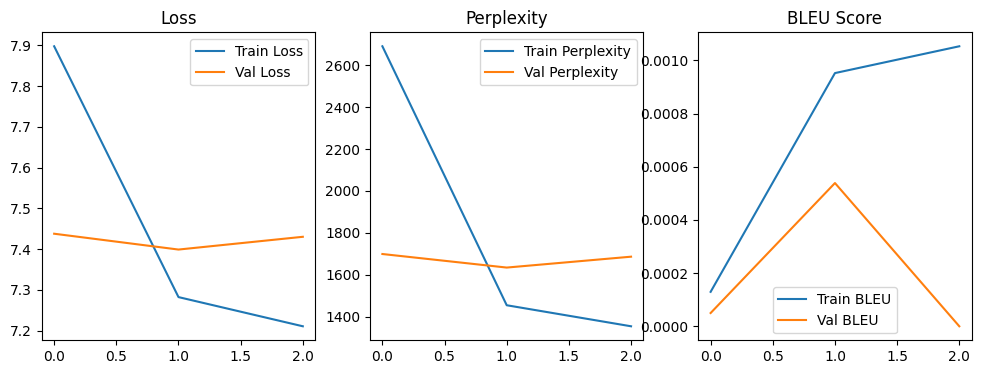

In [14]:
tokenizer = Tokenizer(max_len=CFG.max_seq_len)
model = Transformer(vocab_size=tokenizer.vocab_size)
train_losses, val_losses, train_perplexities, val_perplexities, train_bleus, val_bleus = train_model(model, train_dl, val_dl, tokenizer, epochs=3)
test_loss, test_perplexity, test_bleu = evaluate_model(model, test_dl, tokenizer)